In [ ]:
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
def display_maze(maze):
    plt.imshow(maze)
    plt.show()

In [ ]:
import numpy
from numpy.random import randint as rand
import matplotlib.pyplot as pyplot

def maze(width=84, height=84, complexity=.75, density=.75):
    # Only odd shapes
    shape = ((height // 2) * 2 + 1, (width // 2) * 2 + 1)
    # Adjust complexity and density relative to maze size
    complexity = int(complexity * (5 * (shape[0] + shape[1]))) # number of components
    density    = int(density * ((shape[0] // 2) * (shape[1] // 2))) # size of components
    # Build actual maze
    Z = numpy.zeros(shape, dtype=bool)
    # Fill borders
    Z[0, :] = Z[-1, :] = 1
    Z[:, 0] = Z[:, -1] = 1
    # Make aisles
    for i in range(density):
        x, y = rand(0, shape[1] // 2) * 2, rand(0, shape[0] // 2) * 2 # pick a random position
        Z[y, x] = 1
        for j in range(complexity):
            neighbours = []
            if x > 1:             neighbours.append((y, x - 2))
            if x < shape[1] - 2:  neighbours.append((y, x + 2))
            if y > 1:             neighbours.append((y - 2, x))
            if y < shape[0] - 2:  neighbours.append((y + 2, x))
            if len(neighbours):
                y_,x_ = neighbours[rand(0, len(neighbours) - 1)]
                if Z[y_, x_] == 0:
                    Z[y_, x_] = 1
                    Z[y_ + (y - y_) // 2, x_ + (x - x_) // 2] = 1
                    x, y = x_, y_
    return Z

pyplot.imshow(maze(50, 50), cmap=pyplot.cm.binary, interpolation='nearest')
pyplot.xticks([]), pyplot.yticks([])
pyplot.show()

In [ ]:
from environment.util.dungeon import Generator

def generate_maze(size):
    gen = Generator(width=size[1], height=size[0], tiles = dict(
        stone = 0,
        floor = 1,
        wall = 0
    ))
    gen.gen_level()
    gen.gen_tiles_level()
    return np.array(gen.tiles_level)


pyplot.imshow(generate_maze((20,20)).astype(np.float32), cmap=pyplot.cm.binary, interpolation='nearest')
pyplot.xticks([]), pyplot.yticks([])
pyplot.show()

In [ ]:
from graph.dungeon_graph import DungeonGraph
size = (20,20)

graph = DungeonGraph(size)
pyplot.imshow(graph.maze.astype(np.float32), cmap=pyplot.cm.binary, interpolation='nearest')
pyplot.xticks([]), pyplot.yticks([])
pyplot.show()

In [ ]:
from graph.env import SimpleGraphEnv

env = SimpleGraphEnv(graph, graph.goal)
env.unwrapped.set_complexity(1.0)
print(env.largest_distance)
obs = env.reset()

plt.imshow(obs, interpolation='nearest')
plt.show()

In [ ]:
# from graph.util import dump_graph

#for i in range(1, 32):
#    with open('./scenes/dungeon-20-%s.pkl' % i, 'wb+') as f:
#        dump_graph(DungeonGraph((20, 20)), f)

In [ ]:
for i in range(1, 32):
    with open('./scenes/dungeon-20-%s.pkl' % i, 'wb+') as f:
        dump_graph(DungeonGraph((20, 20)), f)

# Learning algo

DQN and A2C algorithms will be used to solve the problem of navigation in those scenes.
Furthermode, the influence of scenedifficulty coeffieent is exploited for DQN

In [7]:
from deepq import dqn as dqn
from common.train_wrappers import wrap

import gym
from functools import reduce
from keras.layers import Input, Dense, Concatenate, Lambda, PReLU
from keras.models import Model
import keras.backend as K
from common import register_trainer, make_trainer, register_agent, make_agent

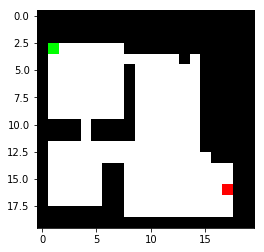

In [8]:
from graph.env import SimpleGraphEnv
from graph.util import load_graph
from gym.wrappers import TimeLimit

size = (20, 20)

with open('./scenes/dungeon-%s-1.pkl' % size[0], 'rb') as f:
    graph = load_graph(f)

env = TimeLimit(SimpleGraphEnv(graph, graph.goal), max_episode_steps = 100)
env.unwrapped.set_complexity(None)
obs = env.reset()

plt.imshow(obs, interpolation='nearest')
plt.show()

In [12]:
from deepq.models import atari

@register_trainer('deepq-dungeon', max_time_steps = 2000, episode_log_interval = 10)
class Trainer(dqn.DeepQTrainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.epsilon_start = 1.0
        self.epsilon_end = 0.02
        self.annealing_steps = 10000
        self.preprocess_steps = 1000
        self.replay_size = 50000
        self.minibatch_size = 32
        self.gamma = 0.95
        self.max_episode_steps = None

    def create_inputs(self, name, **kwargs):
        return [Input(shape = size + (3,), name = name + '_input')]

    def create_model(self, inputs, **kwargs):
        return atari(inputs, 4)

    def wrap_env(self, env):
        return env
    
trainer = make_trainer(
    id = 'deepq-dungeon',
    env_kwargs = env,
    model_kwargs = dict(action_space_size = 4)
)

trainer.run()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 20, 20, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 4, 4, 32)     6176        main_input[0][0]                 
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 1, 1, 32)     16416       conv1[0][0]                      
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 32)           0           conv2[0][0]                      
__________________________________________________________________________________________________
state_fc_1

In [ ]:
from eval import Evaluation
import gym
import gym.wrappers
from common import make_agent
from graph.env import SimpleGraphEnv
from graph.util import load_graph
import experiments.dungeon_dqn
with open('./scenes/dungeon-20-1.pkl', 'rb') as f:
    graph = load_graph(f)
env = gym.wrappers.TimeLimit(SimpleGraphEnv(graph, graph.goal), max_episode_steps = 100)
evaluation = Evaluation(env) #, number_of_episodes = 100)
evaluation.run(make_agent('deepq-dungeon'))

print(evaluation.results)

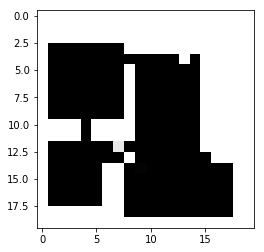

In [13]:
state = env.reset()

Q = np.zeros((20,20,4), dtype = np.float32)
for y in range(20):
    for x in range(20):
        observation = env.unwrapped.observe((y,x))
        #plt.imshow(observation)
        #plt.show()
        Q[x,y,:] = trainer.unwrapped._q(observation[None])[0]
            
V = np.max(Q, 2)

min_v = np.min(V)
max_v = np.max(V)
V = (V - min_v) / (max_v - min_v)

# Remove maze
V[env.unwrapped.graph.maze == 0] = 1

img = plt.imshow(V, interpolation='none', cmap='gray')
plt.show()

print(v)

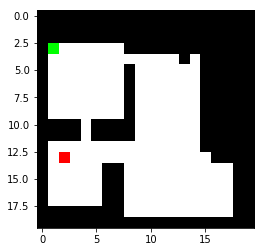

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


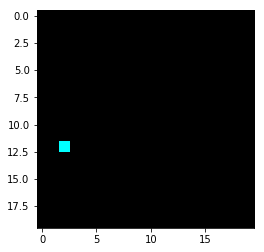

4.0

In [14]:
s1 = env.reset()
plt.imshow(s1)
plt.show()
s2, _, _, _ = env.step(2)
plt.imshow(s1-s2, interpolation = 'nearest')
plt.show()
np.sum(np.abs(s1-s2))

In [15]:
with open('./scenes/dungeon-20-1.pkl', 'rb') as f:  #dungeon-%s-1.pkl' % size[0]
    graph = load_graph(f)

env = TimeLimit(SimpleGraphEnv(graph, graph.goal), max_episode_steps = 100)

import baselines.deepq
act = baselines.deepq.learn(env, 'mlp', lr = 0.001, )

Logging to /tmp/openai-2019-02-22-00-57-13-842168


/home/jonas/tensorflow/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jonas/tensorflow/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonas/tensorflow/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jonas/tensorflow/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonas/tensorflow/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jonas/tensorflow/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonas/tensorflow/lib/python3.6/site-packages/n

--------------------------------------
| % time spent exploring  | 10       |
| episodes                | 100      |
| mean 100 episode reward | 0.2      |
| steps                   | 9139     |
--------------------------------------
Saving model due to mean reward increase: None -> 0.2
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 200      |
| mean 100 episode reward | 0.4      |
| steps                   | 16834    |
--------------------------------------
Saving model due to mean reward increase: 0.2 -> 0.4
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 300      |
| mean 100 episode reward | 0.4      |
| steps                   | 24548    |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 400      |
| mean 100 episode reward | 0.5      |
| steps                   | 31844  

In [22]:
act(env.unwrapped.observe((4,1)))

array([0])